In [34]:
!pip install -r requirements.txt

Ignoring async-timeout: markers 'python_version >= "3.11" and python_full_version < "3.11.3"' don't match your environment
Ignoring colorama: markers 'python_version >= "3.11" and python_version < "3.12" and (platform_system == "Windows" or os_name == "nt" or sys_platform == "win32")' don't match your environment
Ignoring nvidia-cublas-cu12: markers 'platform_system == "Linux" and platform_machine == "x86_64" and python_version >= "3.11" and python_version < "3.12"' don't match your environment
Ignoring nvidia-cuda-cupti-cu12: markers 'platform_system == "Linux" and platform_machine == "x86_64" and python_version >= "3.11" and python_version < "3.12"' don't match your environment
Ignoring nvidia-cuda-nvrtc-cu12: markers 'platform_system == "Linux" and platform_machine == "x86_64" and python_version >= "3.11" and python_version < "3.12"' don't match your environment
Ignoring nvidia-cuda-runtime-cu12: markers 'platform_system == "Linux" and platform_machine == "x86_64" and python_version

In [36]:
from dotenv import load_dotenv
load_dotenv()

True

In [37]:
from langchain_teddynote import logging
logging.langsmith("AI-AGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
AI-AGENT


# MCP 

LangGraph 기반으로 MCP 개념을 반영

In [38]:
from pydantic import BaseModel
from typing import Dict, Any
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage

## 1. 모델 정의

In [39]:
llm = ChatOpenAI(model='gpt-4o', temperature=0)

## 2. Agent 정의

In [40]:
search_prompt = SystemMessage(content="당신은 검색 전문가입니다. 전기차 시장 관련 최신 뉴스들을 검색하고 정리한 내용들을 출력하세요.")
derivate_prompt = SystemMessage(content="당신은 도출 전문가입니다. 소비자 우려 요인을 도출하고 정리한 내용들을 출력하세요.")
come_up_with_prompt = SystemMessage(content="당신은 기획 전문가입니다. 마케팅 캠페인 아이디어를 생성하고 정리한 내용들을 출력하세요.")
documentate_prompt = SystemMessage(content="당신은 문서화 전문가입니다. 결과들을 정리 후 제안서를 생성 및 저장하세요.")

In [41]:
# MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
class AgentState(BaseModel):
    topic: str
    context: Dict[str, Any]

In [42]:
def search_agent(state: AgentState) -> AgentState:
    topic = state.topic 
    
    messages = [
        search_prompt,
        {"role": "user", "content": f"{topic}에 대해 조사해 주세요."}
    ]

    search_result = llm.invoke(messages)

    # MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
    return AgentState(
        topic=state.topic,
        context={
            "agent": "SearchAgent",
            "task": "search",
            "result": search_result.content
        }
    )

In [43]:
def derivate_agent(state: AgentState) -> AgentState:
    search_text = state.context["result"]

    messages = [
        derivate_prompt,
        {"role": "user", "content": f"다음 정보에서 소비자 우려 요인을 도출해주세요:\n{search_text}"}
    ]

    derivate_result = llm.invoke(messages)

    # MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
    return AgentState(
        topic=state.topic,
        context={
            "agent": "DerivateAgent",
            "task": "derivate",
            "result": derivate_result.content
        }
    )

In [44]:
def come_up_with_agent(state: AgentState) -> AgentState:
    derivate_text = state.context["result"]

    messages = [
        come_up_with_prompt,
        {"role": "user", "content": "다음 소비자 우려 요인들로 마케팅 캠페인 아이디어를 생성해주세요:\n{derivate_text}"}
    ]

    come_up_with_result = llm.invoke(messages)

    # MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
    return AgentState(
        topic=state.topic,
        context={
            "agent": "ComeupwithAgent",
            "task": "come_up_with",
            "result": come_up_with_result.content
        }
    )

In [45]:
def documentate_agent(state: AgentState) -> AgentState:
    come_up_with_text = state.context["result"]

    messages = [
        documentate_prompt,
        {"role": "user", "content": f"다음 정보를 문서화해 요약해주세요:\n{come_up_with_text}"}
    ]

    documentate_result = llm.invoke(messages)

    # MCP 사상 반영: 에이전트별 task와 결과를 context로 저장
    return AgentState(
        topic=state.topic,
        context={
            "agent": "DocumentateAgent",
            "task": "documentate",
            "result": documentate_result.content
        }
    )

## 3. Workflow 설계

In [46]:
workflow = StateGraph(AgentState)

workflow.add_node("search", search_agent)
workflow.add_node("derivate", derivate_agent)
workflow.add_node("come_up_with", come_up_with_agent)
workflow.add_node("documentate", documentate_agent)

# 엔트리 포인트 설정
workflow.set_entry_point("search")

# 엣지 설정
workflow.add_edge("search", "derivate")
workflow.add_edge("derivate", "come_up_with")
workflow.add_edge("come_up_with", "documentate")
workflow.add_edge("documentate", END)

# 그래프 컴파일
graph = workflow.compile()

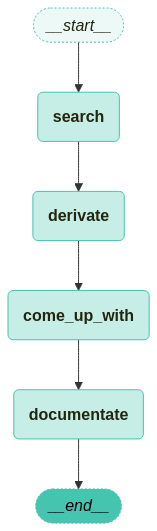

In [47]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 4. 실행

In [48]:
# 실행 예시
initial_state = {
    "topic": "전기차 시장의 최근 이슈",
    "context": {}
}

In [49]:
result = graph.invoke(initial_state)
print("🔍 조사 내용:\n", result["context"]["result"])

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

--------
** End of Documents **